In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import UnivariateSpline
import lmfit
import ray


from bio_optics.water import absorption, attenuation, backscattering, scattering, lee
from bio_optics.atmosphere import downwelling_irradiance
from bio_optics.models import hereon, model, bandratioIOPprediction
from bio_optics.helper import resampling, utils, owt, indices, plotting

In [2]:
## Jorge: Spec Balaton
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\Others\SpecBal_EnMap.txt', index_col=0)

r_rs = df.iloc[:,:56] 
wavelengths = df.columns[:56].values.astype(float)
print(df.columns.values)

['418.2' '423.9' '429.3' '434.5' '439.6' '444.5' '449.4' '454.2' '458.9'
 '463.6' '468.3' '472.9' '477.6' '482.3' '486.9' '491.6' '496.3' '501.1'
 '505.9' '510.7' '515.5' '520.4' '525.3' '530.3' '535.3' '540.3' '545.4'
 '550.5' '555.7' '560.9' '566.2' '571.6' '577.0' '582.5' '588.0' '593.6'
 '599.3' '605.0' '610.8' '616.7' '622.7' '628.8' '634.9' '641.1' '647.3'
 '653.6' '660.0' '666.4' '672.9' '679.5' '686.1' '692.8' '699.6' '706.4'
 '713.3' '720.3' '727.3' '734.4' '741.6' '748.8' '756.1' '763.5' '770.9'
 '778.3' '785.8' '793.4' 'Date/Time' 'Lat' 'Lon' 'Location' 'Set' 'QWIP'
 'NDI' 'AVW' 'W_Chl' 'W_TSM' 'W_Kd' 'W_CPC' 'Turbidity' 'CDOM' 'Diatoms'
 'Cryptophyta' 'Planktothrix' 'Green_algae' 'Ratio' 'Chl_a' 'Cyano']


In [3]:
from bio_optics.water import fluorescence

# global inputs that don't change with fit params
a_md_spec_res = absorption.a_md_spec(wavelengths=wavelengths)
a_bd_spec_res = absorption.a_bd_spec(wavelengths=wavelengths)
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec_EnSAD(wavelengths=wavelengths)
b_bw_res = backscattering.b_bw(wavelengths=wavelengths, fresh=False)
b_i_spec_res = resampling.resample_b_i_spec_EnSAD(wavelengths=wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths=wavelengths)
h_C_res = fluorescence.h_C_double(wavelengths=wavelengths, W=0.75)
h_C_phycocyanin_res = fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=644)
h_C_phycoerythrin_res =fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=573)
omega_d_lambda_0_res = attenuation.omega_d_lambda_0()

E_0_res = resampling.resample_E_0(wavelengths=wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

E_dd_res = downwelling_irradiance.E_dd(wavelengths=wavelengths)
E_dsa_res = downwelling_irradiance.E_dsa(wavelengths=wavelengths)
E_dsr_res = downwelling_irradiance.E_dsr(wavelengths=wavelengths)
E_d_res = E_dd_res + E_dsa_res + E_dsr_res

In [4]:
weights = np.ones(len(wavelengths))

In [7]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=1000, vary=False) # brown
params.add('C_1', value=1, min=1e-10, max=1000, vary=False) # green
params.add('C_2', value=0, min=0, max=1000, vary=False) # cryptophyte
params.add('C_3', value=0, min=0, max=1000, vary=False) # cyano blue
params.add('C_4', value=0, min=0, max=1000, vary=False) # cyano red
params.add('C_5', value=0, min=0, max=1000, vary=False) # coccolithophores
params.add('C_6', value=0, min=0, max=1000, vary=False) # dinoflagellates
params.add('C_7', value=0, min=0, max=1000, vary=False) # case-1
params.add('C_Y', value=0.1, min=0, max=20, vary=True) 
params.add('C_ism', value=1, min=0, max=100, vary=True)
params.add('L_fl_lambda0', value=0, min=0, max=0.2, vary=True)
params.add('L_fl_phycocyanin', value=0, min=0, max=0.2, vary=True)
params.add('L_fl_phycoerythrin', value=0, min=0, max=0.2, vary=True)
params.add('b_ratio_C_0', value=0.002, vary=False) # brown
params.add('b_ratio_C_1', value=0.007, vary=False) # green
params.add('b_ratio_C_2', value=0.002, vary=False) # cryptophyte
params.add('b_ratio_C_3', value=0.001, vary=False) # cyano blue
params.add('b_ratio_C_4', value=0.001, vary=False) # cyano red
params.add('b_ratio_C_5', value=0.007, vary=False) # coccolithophores
params.add('b_ratio_C_6', value=0.007, vary=False) # dinoflagellates , chose 0.007 because of smaller cell size
params.add('b_ratio_C_7', value=0.007, vary=False) # case-1
params.add('b_ratio_md', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
params.add('b_ratio_bd', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
params.add('A_md', value=13.4685e-3, vary=False)
params.add('A_bd', value=0.3893e-3, vary=False)
params.add('S_md', value=10.3845e-3, vary=False)
params.add('S_bd', value=15.7621e-3, vary=False)
params.add('S_cdom', value=0.0185, min=0.005, max=0.032, vary=True)
params.add('C_md', value=12.1700e-3, vary=False)
params.add('C_bd', value=0.9994e-3, vary=False)
params.add('K', value=0, min=0, vary=False)
params.add('lambda_0_cdom', value=440, vary=False)
params.add('lambda_0_md', value=550, vary=False)
params.add('lambda_0_bd', value=550, vary=False)
params.add('lambda_0_c_d', value=550, vary=False)
params.add('lambda_0_phy', value=676, vary=False)
params.add('gamma_d', value=0.3835, vary=False)
params.add('x0', value=1, vary=False)
params.add('x1', value=10, vary=False)
params.add('x2', value=-1.3390, min=-1.3390-0.0618, max=-1.3390+0.0618, vary=False)
params.add('A', value=0.0237, vary=False)
params.add('E0', value=1, vary=False)
params.add('E1', value=0.8987, vary=False)
params.add('W', value=0.75, vary=False) 
params.add('fwhm1', value=25, vary=False)
params.add('fwhm2', value=50, vary=False)
params.add('fwhm_phycocyanin', value=20, vary=False)
params.add('fwhm_phycoerythrin', value=20, vary=False)
params.add('lambda_C1', value=685, vary=False)
params.add('lambda_C2', value=730, vary=False)
params.add('lambda_C_phycocyanin', value=644, vary=False)
params.add('lambda_C_phycoerythrin', value=573, vary=False)
params.add('double', value=True, vary=False)
params.add('interpolate', value=True, vary=False)
params.add("Gw0", value=0.05881474, vary=False)
params.add("Gw1", value=0.05062697, vary=False)
params.add("Gp0", value=0.03997009, vary=False)
params.add("Gp1", value=0.1398902, vary=False)
params.add('error_method', value=0, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(1e-10), min=np.radians(1e-10), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('offset', value=0, min=-0.1, max=0.1, vary=False) #min= -0.1
params.add('fit_surface', value=True, vary=True)

In [6]:
## Filtering the data
PhytoConcInsituCol = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity']
a = np.zeros(df.shape[0])
for phyto in PhytoConcInsituCol[:4]:
    print(phyto, np.sum(np.isnan(df[phyto].values)))
    a += np.isnan(df[phyto].values)
ID = np.array(a==0)
print(np.sum(ID), len(a))

df = df.loc[ID,:]
r_rs = r_rs.loc[ID,:]

Diatoms 685
Green_algae 685
Cryptophyta 685
Cyano 0
294 979


# Inversion with one free Phytoplankton per Run

In [41]:
import datetime as dtime
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"

PhytoConcInsituCol = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'CDOM', 'Turbidity']
for phyto in PhytoConcInsituCol:
    print(phyto, np.sum(np.isnan(df[phyto].values)))

## run through 
CHL_paramList = ['C_0', 'C_1', 'C_2', 'C_3', 'C_4', 'C_6']

for CHL_param in CHL_paramList[-1:]:
    print(CHL_param)
    out = None
    R_rs_surf = np.zeros((r_rs.shape[0], len(wavelengths)))
    R_rs_sim = np.zeros((r_rs.shape[0], len(wavelengths)))
    time1 = dtime.datetime.now()
    for i in range(r_rs.shape[0]):
        chunk_params = params.copy()
        chunk_params.add(CHL_param, value=0, min=0, max=1000, vary=True)
        FreeParamList = [a for a in chunk_params.keys() if chunk_params[a].vary]
        inv = hereon.invert(chunk_params, 
                            R_rs=r_rs.iloc[i,:],
                            Ls_Ed = [],
                            wavelengths=wavelengths, 
                            weights=weights,
                            a_md_spec_res = a_md_spec_res,
                            a_bd_spec_res = a_bd_spec_res,
                            a_w_res = a_w_res,
                            a_i_spec_res = a_i_spec_res,
                            b_bw_res = b_bw_res, 
                            b_i_spec_res = b_i_spec_res,
                            h_C_res = h_C_res,
                            h_C_phycocyanin_res=h_C_phycocyanin_res,
                            h_C_phycoerythrin_res=h_C_phycoerythrin_res,
                            da_W_div_dT_res = da_W_div_dT_res,
                            E_0_res = E_0_res,
                            a_oz_res = a_oz_res,
                            a_ox_res = a_ox_res,
                            a_wv_res = a_wv_res,
                            E_dd_res = E_dd_res,
                            E_dsa_res = E_dsa_res,
                            E_dsr_res = E_dsr_res,
                            E_d_res = E_d_res,
                            n2_res = n2_res,
                            method="least_squares",
                            max_nfev=1500)
    
        if out is None:
            out = np.zeros((r_rs.shape[0], len(FreeParamList)))
        for j, p in enumerate(FreeParamList):
            # print(p, np.round(inv.params[p].value,4))
            out[i, j] = inv.params[p].value
    
        if params['fit_surface'].value:
            R_rs_surf[i,:] = model.forward_glint(wavelengths=wavelengths,
                                        parameters=inv.params,
                                        E_d_res=E_d_res,
                                        E_dd_res=E_dd_res,
                                        E_dsa_res=E_dsa_res,
                                        E_dsr_res=E_dsr_res,
                                        n2_res=n2_res,
                                        Ls_Ed=[])
    
    
        R_rs_sim[i,:] =hereon.forward(parameters=inv.params, 
                                             wavelengths=wavelengths, 
                                             a_md_spec_res = a_md_spec_res,
                                             a_bd_spec_res = a_bd_spec_res,
                                             a_w_res = a_w_res,
                                             a_i_spec_res = a_i_spec_res,
                                             b_bw_res = b_bw_res, 
                                             b_i_spec_res = b_i_spec_res,
                                             h_C_res=h_C_res,
                                             h_C_phycocyanin_res = h_C_phycocyanin_res,
                                             h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                             da_W_div_dT_res = da_W_div_dT_res,
                                             E_0_res = E_0_res,
                                             a_oz_res = a_oz_res,
                                             a_ox_res = a_ox_res,
                                             a_wv_res = a_wv_res,
                                             E_dd_res = E_dd_res,
                                             E_dsa_res = E_dsa_res,
                                             E_dsr_res = E_dsr_res,
                                             E_d_res = E_d_res,
                                             n2_res = n2_res,
                                             Ls_Ed=[])


    time2 = dtime.datetime.now()
    print('total conversion N=', r_rs.shape[0], time2 - time1)
    
    ## write output
    ## write modelled spectra
    if params['fit_surface'].value:
        R_rs_surf = pd.DataFrame(R_rs_surf, columns=wavelengths.astype(str))
        R_rs_surf.to_csv(outpath + "inversion_RrsGlint_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt", header=True, sep='\t', index=False)
    
    R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))
    R_rs_sim.to_csv(outpath + "inversion_Rrs_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt", header=True, sep='\t', index=False)
    
    outDF = pd.DataFrame(out, columns=FreeParamList)
    outDF.to_csv(outpath + "inversionIOP_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt", sep='\t', header=True, index=False)

Diatoms 0
Green_algae 0
Cryptophyta 0
Cyano 0
CDOM 0
Turbidity 223
C_6
total conversion N= 294 0:05:05.162314


## Analyse 1-Group inversions
### Goodness of fit and IOP

In [42]:
path =  r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\analyse_SpecBal\\"
colorList = ['lightcoral', 'chocolate', 'goldenrod', 'darkkhaki', 'yellowgreen', 'cadetblue', 'orchid', 'slateblue']
IOPResultDict = {}
for i, CHL_param in enumerate(CHL_paramList):
    IOPResultDict[CHL_param] = {}
    IOPResultDict[CHL_param]['fname'] = "inversionIOP_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt"
    IOPResultDict[CHL_param]['col'] = colorList[i]

dDict = {}
for key in IOPResultDict.keys():
    dDict[key] = pd.read_csv(outpath + IOPResultDict[key]['fname'], sep='\t', header=0)

RrsResultDict = {}
for i, CHL_param in enumerate(CHL_paramList):
    RrsResultDict[CHL_param] = {}
    RrsResultDict[CHL_param]['fname'] = "inversion_Rrs_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt"
    RrsResultDict[CHL_param]['glint_fname'] = "inversion_RrsGlint_SpecBal_varChl1_"+CHL_param+"_withPosGlint_md_bd_conFL.txt"
    RrsResultDict[CHL_param]['col'] = colorList[i]

rrsDict = {}
for key in RrsResultDict.keys():
    rrsDict[key] = pd.read_csv(outpath + RrsResultDict[key]['fname'], sep='\t', header=0)

In [43]:
# Error, Residuals of spectral fit
SpectralErrorDict={}

for key in RrsResultDict.keys():
    rMAE = np.zeros(r_rs.shape[0])
    sam = np.zeros(r_rs.shape[0])
    
    for i in range(len(rMAE)):
        rMAE[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, rrsDict[key].iloc[i,:].values, method=11))
        sam[i] = np.sum(r_rs.iloc[i].values * rrsDict[key].iloc[i,:].values)/\
                     (np.sqrt(np.sum(r_rs.iloc[i].values*r_rs.iloc[i].values)) * np.sqrt(np.sum(rrsDict[key].iloc[i,:].values*rrsDict[key].iloc[i,:].values)))
        sam[i] = np.arccos(sam[i])
        
    sam *=180./np.pi
    SpectralErrorDict[key] = {}
    SpectralErrorDict[key]['rMAE'] = rMAE
    SpectralErrorDict[key]['SAM'] = sam

    dsurf = pd.read_csv(path + RrsResultDict[key]['glint_fname'], header=0, sep='\t')
    glintStrength = np.mean(dsurf/r_rs, axis=1)
    SpectralErrorDict[key]['glint'] = glintStrength
    

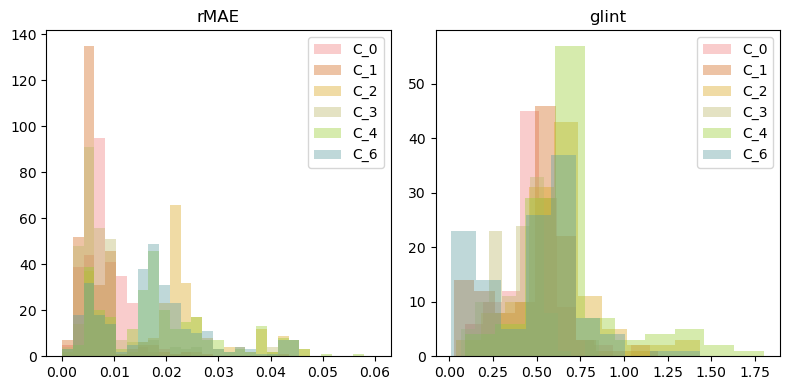

In [44]:
## histogram rMAE and glint strength
Nx = 2
bins = np.linspace(0.00, 0.06, 30)
fig, ax = plt.subplots(nrows=1, ncols=Nx, figsize=(8,4))
for key in SpectralErrorDict.keys():
    ax[0].hist(SpectralErrorDict[key]['rMAE'], bins=bins, color=RrsResultDict[key]['col'], alpha=0.4, label=key)
    ax[1].hist(SpectralErrorDict[key]['glint'],  color=RrsResultDict[key]['col'], alpha=0.4, label=key)

ax[0].set_title('rMAE')
ax[1].set_title('glint')
for i in range(Nx):
    ax[i].legend()

fig.tight_layout()
plt.show()


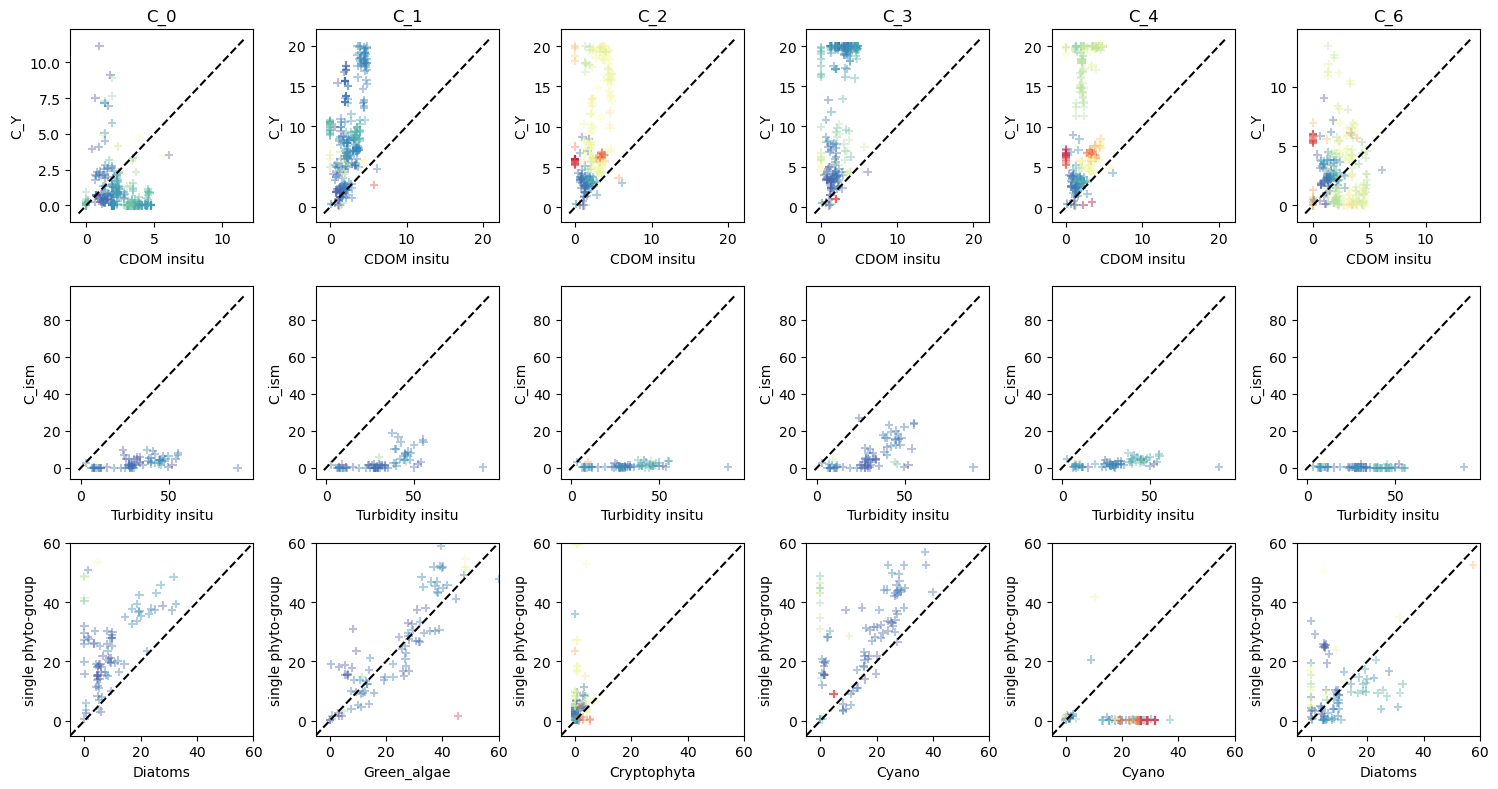

In [48]:
colorMap = plt.cm.get_cmap('Spectral_r')
Nx = len(CHL_paramList)
Ny = 3

totChl_insitu = np.nansum(df[PhytoConcInsituCol[:4]], axis=1)
vmax = 0.048

fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(15, 8))
for ix, key in enumerate(SpectralErrorDict.keys()):
    ax[0, ix].scatter(df['CDOM'], dDict[key]['C_Y'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=vmax, alpha=0.4)
    ax[0, ix].set_xlabel('CDOM insitu')
    ax[0, ix].set_ylabel('C_Y')
    ax[0, ix].set_title(key)

for ix, key in enumerate(SpectralErrorDict.keys()):
    ax[1, ix].scatter(df['Turbidity'], dDict[key]['C_ism'], marker='+', c=SpectralErrorDict[key]['rMAE'], cmap=colorMap, vmin=0.00115, vmax=vmax, alpha=0.4)
    ax[1, ix].set_xlabel('Turbidity insitu')
    ax[1, ix].set_ylabel('C_ism')

# single phytoplankton group only!
insituList = ['Diatoms', 'Green_algae', 'Cryptophyta', 'Cyano', 'Cyano', 'Diatoms'] 
for ix, key in enumerate(SpectralErrorDict.keys()):
    totChl = dDict[key][key].values
    ID = np.array(totChl > 0.1)
    ax[2, ix].scatter(df[insituList[ix]][ID], totChl[ID], marker='+', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=vmax, alpha=0.4)
    # ax[2, ix].scatter(totChl_insitu[ID], totChl[ID], marker='+', c=SpectralErrorDict[key]['rMAE'][ID], cmap=colorMap, vmin=0.00115, vmax=vmax, alpha=0.4)
    ax[2, ix].set_xlabel(insituList[ix])
    ax[2, ix].set_ylabel('single phyto-group')
    # xlim = ax[2, ix].get_xlim()
    ax[2, ix].set_xlim((-5, 60.))
    # ax[2, ix].set_ylim((-1., 300.))


for i in range(Nx):
    for j in range(Ny-1):
        lim = np.array( (np.min((ax[j,i].get_xlim(), ax[j,i].get_ylim())), np.max((ax[j,i].get_xlim(), ax[j,i].get_ylim()))))
        ax[j,i].plot(lim, lim, 'k--')

j = Ny-1
for i in range(Nx):
    lim = np.array( (np.min((ax[j,i].get_xlim())), np.max((ax[j,i].get_xlim()))))
    ax[j,i].plot(lim, lim, 'k--')
    ax[j,i].set_ylim(lim)

fig.tight_layout()
plt.show()